In [31]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [5]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

print("class_names_label", class_names_label)
print("nb_classes", nb_classes)

IMAGE_SIZE = (150, 150)

class_names_label {'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5}
nb_classes 6


In [32]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = [r'C:\Users\PC\OneDrive\Desktop\seg_train',r'C:\Users\PC\OneDrive\Desktop\seg_test' ]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [34]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\PC\OneDrive\Desktop\seg_train


100%|██████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:35<00:00, 67.28it/s]


Loading C:\Users\PC\OneDrive\Desktop\seg_test


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:09<00:00, 51.30it/s]


In [35]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

print(train_labels.shape)
print(test_labels.shape)


Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)
(14034,)
(3000,)


In [36]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [37]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

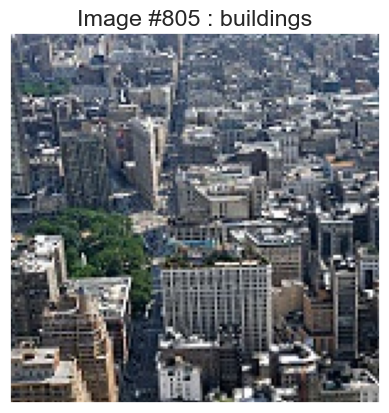

In [38]:
display_random_image(class_names, train_images, train_labels)

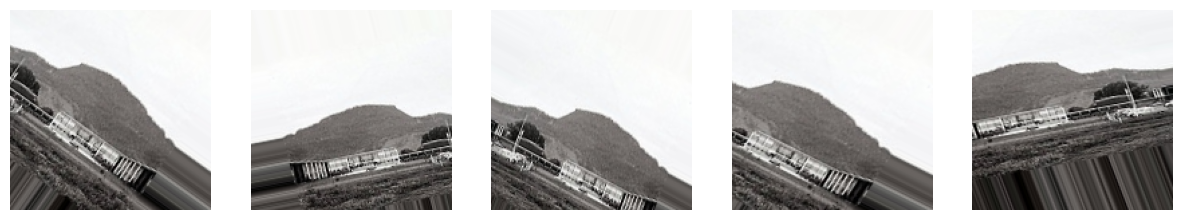

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualize a few augmented images
example_image = train_images[0]
example_image = example_image.reshape((1,) + example_image.shape)  # Reshape to (1, height, width, channels)

fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, augmented_image in enumerate(datagen.flow(example_image, batch_size=1)):
    ax[i].imshow(augmented_image[0])
    ax[i].axis('off')

    if i == 4:
        break

plt.show()


In [41]:
# Create an instance of the ImageDataGenerator with augmentation parameters for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an instance of the ImageDataGenerator without augmentation for validation
val_datagen = ImageDataGenerator()


In [42]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
      
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                      

In [44]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with data augmentation for training data and without augmentation for validation data
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=32),
    steps_per_epoch=len(train_images) // 32,
    epochs=20,
    validation_data=val_datagen.flow(test_images, test_labels, batch_size=32),
    validation_steps=len(test_images) // 32,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20


438/438 [==============================] - 426s 958ms/step - loss: 1.4518 - accuracy: 0.4814 - val_loss: 1.9771 - val_accuracy: 0.3353


C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
438/438 [==============================] - 415s 947ms/step - loss: 1.1190 - accuracy: 0.5781 - val_loss: 1.1724 - val_accuracy: 0.5736
Epoch 3/20
438/438 [==============================] - 407s 928ms/step - loss: 1.0214 - accuracy: 0.6193 - val_loss: 0.9157 - val_accuracy: 0.6384
Epoch 4/20
438/438 [==============================] - 413s 942ms/step - loss: 0.9486 - accuracy: 0.6470 - val_loss: 1.1902 - val_accuracy: 0.5501
Epoch 5/20
438/438 [==============================] - 381s 869ms/step - loss: 0.8862 - accuracy: 0.6770 - val_loss: 1.0246 - val_accuracy: 0.6442
Epoch 6/20
438/438 [==============================] - 384s 876ms/step - loss: 0.8543 - accuracy: 0.6913 - val_loss: 2.2552 - val_accuracy: 0.4550


In [45]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

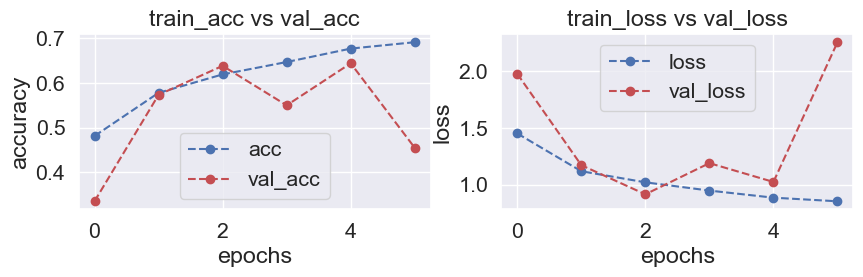

In [46]:
plot_accuracy_loss(history)

94/94 - 19s - loss: 0.9134 - accuracy: 0.6390 - 19s/epoch - 206ms/step

Test Accuracy: 0.6389999985694885
94/94 [==============================] - 20s 212ms/step


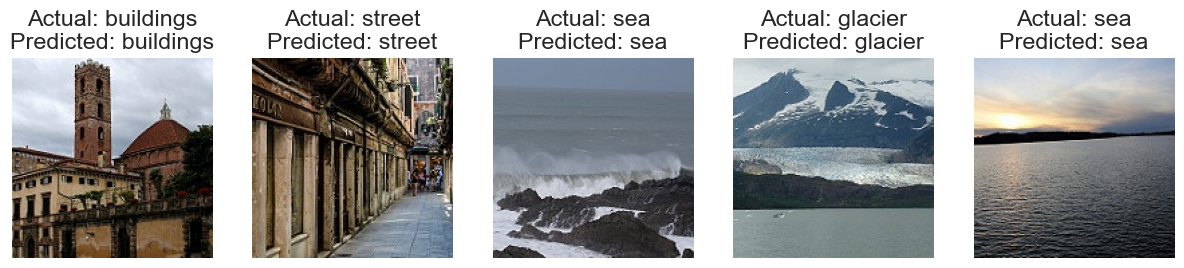

In [48]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print("\nTest Accuracy:", test_accuracy)

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display random images with actual and predicted labels
def display_random_images(images, actual_labels, predicted_labels, class_names, num_images=5):
    indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices, 1):
        plt.subplot(1, num_images, i)
        plt.imshow(images[index])
        plt.title(f"Actual: {class_names[actual_labels[index]]}\nPredicted: {class_names[predicted_labels[index]]}")
        plt.axis('off')

    plt.show()

# Display random images
display_random_images(test_images, test_labels, predicted_labels, class_names)

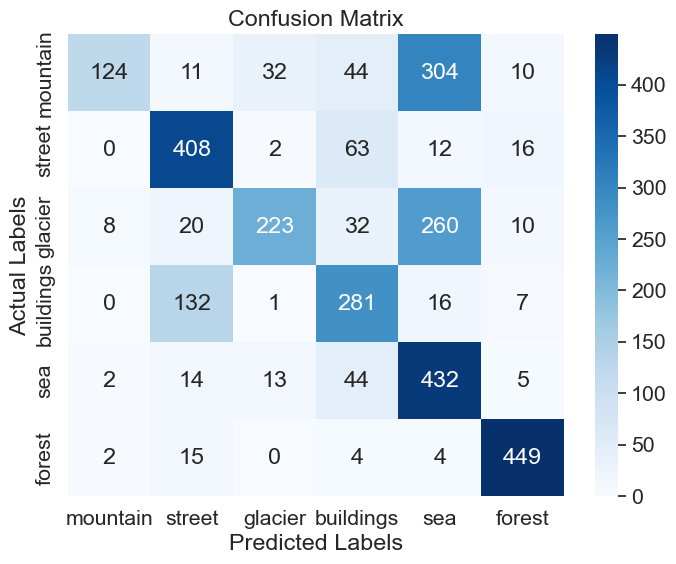

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [50]:
# Load the pre-trained InceptionV3 model without the top layers
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Choose the number of layers to freeze
num_layers_to_freeze = 20

# Freeze only the first num_layers_to_freeze layers
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

87910968/87910968 [==============================] - 37s 0us/step


In [51]:
# Import models module from Keras
from tensorflow.keras import models
# Import necessary layers module from Keras
from tensorflow.keras import layers

# Create a new model by adding custom layers on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(nb_classes, activation='softmax')
])

In [52]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
# Create an instance of the ImageDataGenerator with augmentation parameters for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an instance of the ImageDataGenerator without augmentation for validation
val_datagen = ImageDataGenerator()

In [54]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_vgg16.h5', save_best_only=True)

In [55]:
# Train the model with data augmentation for training data and without augmentation for validation data
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=32),
    steps_per_epoch=len(train_images) // 32,
    epochs=20,
    validation_data=val_datagen.flow(test_images, test_labels, batch_size=32),
    validation_steps=len(test_images) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
438/438 [==============================] - ETA: 0s - loss: 1.4865 - accuracy: 0.3809

C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 805s 2s/step - loss: 1.4865 - accuracy: 0.3809 - val_loss: 1.0766 - val_accuracy: 0.4929
Epoch 2/20
438/438 [==============================] - 856s 2s/step - loss: 1.0276 - accuracy: 0.5681 - val_loss: 0.8652 - val_accuracy: 0.6418
Epoch 3/20
438/438 [==============================] - 743s 2s/step - loss: 0.9421 - accuracy: 0.6298 - val_loss: 0.9575 - val_accuracy: 0.6183
Epoch 4/20
438/438 [==============================] - 759s 2s/step - loss: 0.8713 - accuracy: 0.6603 - val_loss: 1.4192 - val_accuracy: 0.4677
Epoch 5/20
438/438 [==============================] - 822s 2s/step - loss: 0.9250 - accuracy: 0.6607 - val_loss: 0.7869 - val_accuracy: 0.6962
Epoch 6/20
438/438 [==============================] - 820s 2s/step - loss: 0.7979 - accuracy: 0.7418 - val_loss: 0.7433 - val_accuracy: 0.7806
Epoch 7/20
438/438 [==============================] - 817s 2s/step - loss: 0.7492 - accuracy: 0.7463 - val_loss: 0.6401 - val_accuracy: 0.7409
Epoch 8/20

94/94 - 48s - loss: 0.4013 - accuracy: 0.8617 - 48s/epoch - 514ms/step

Test Accuracy: 0.8616666793823242
94/94 [==============================] - 39s 395ms/step


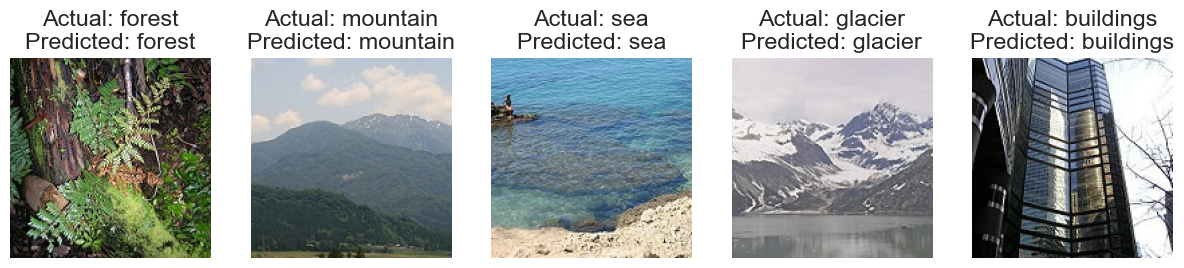

In [56]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print("\nTest Accuracy:", test_accuracy)

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display random images with actual and predicted labels
def display_random_images(images, actual_labels, predicted_labels, class_names, num_images=5):
    indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices, 1):
        plt.subplot(1, num_images, i)
        plt.imshow(images[index])
        plt.title(f"Actual: {class_names[actual_labels[index]]}\nPredicted: {class_names[predicted_labels[index]]}")
        plt.axis('off')

    plt.show()

# Display random images
display_random_images(test_images, test_labels, predicted_labels, class_names)


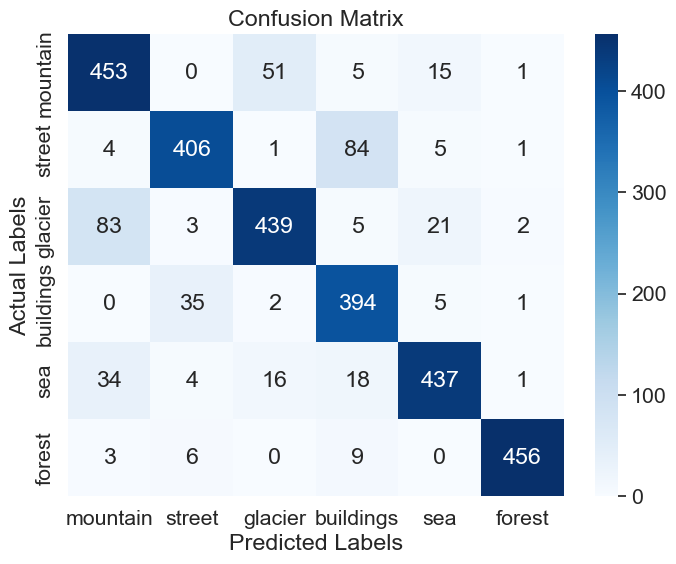

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
